# Van der Waals (VDW) Energy Analysis with abagpdb

This notebook demonstrates how to **calculate and analyze van der Waals interaction energies** at the residue level using the `abagpdb` package.

## Overview

VDW energy analysis helps you:
- **Quantify non-bonded interactions**: Calculate Lennard-Jones energies between residues
- **Identify energetic hotspots**: Find residues with strong VDW contributions
- **Decompose interface energies**: Understand which residues drive binding
- **Compare chain contributions**: Analyze energetic roles of different chains
- **Guide mutagenesis studies**: Identify key residues for experimental validation

## Lennard-Jones 12-6 Potential (AMBER Form)

The VDW energy is calculated using the AMBER 12-6 Lennard-Jones potential:

```
E_ij = ε_ij * [(R_min,ij / r)^12 - 2 * (R_min,ij / r)^6]
```

Where:
- **r**: Distance between atoms i and j (Å)
- **R_min,ij**: Sum of VDW radii (R_min,i/2 + R_min,j/2)
- **ε_ij**: Well depth = √(ε_i × ε_j) (kcal/mol)
- **Negative energy**: Favorable (attractive) interaction
- **Positive energy**: Unfavorable (repulsive) interaction

## Key Concepts

| Term | Definition | Typical Range |
|------|------------|---------------|
| **VDW Energy** | Non-bonded Lennard-Jones energy | -10 to +5 kcal/mol per residue |
| **Hotspot** | Residue with strong interaction | < -2.0 kcal/mol |
| **Favorable** | Attractive interaction | Negative energy |
| **Unfavorable** | Repulsive/clash | Positive energy |
| **Cutoff** | Maximum distance considered | Default: 5.0 Å |

---

## Example: Antibody-Antigen Complex (PDB: 5GGS)

## 1. Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from abagpdb.pdbparser import parse_pdb
from abagpdb.vdw import (
    per_residue_LJ_decomposition,
    per_residue_pair_LJ,
    rank_hotspots,
    identify_energetic_hotspots,
    compare_energetic_contributions,
    print_vdw_report,
    export_vdw_results,
    VDW_RADIUS,
    PER_EPS
)

## 2. Load PDB Structure

In [2]:
# Parse the PDB file
cx = parse_pdb("5GGS_wt.pdb")

print("✓ Structure loaded successfully!")
print(f"  File: {cx.source_path}")
print(f"  Chains: {', '.join(cx.chains.keys())}")

# Count residues per chain
print(f"\nResidue counts:")
for chain_id, chain in cx.chains.items():
    n_residues = len(chain.residues)
    print(f"  Chain {chain_id}: {n_residues} residues")

✓ Structure loaded successfully!
  File: 5GGS_wt.pdb
  Chains: A, H, L

Residue counts:
  Chain A: 113 residues
  Chain H: 219 residues
  Chain L: 217 residues


### VDW Parameters

View the VDW radii and epsilon values used in calculations.

In [3]:
# Display VDW parameters
print("=" * 80)
print("VDW PARAMETERS (AMBER)".center(80))
print("=" * 80)

print("\nVDW Radii (R_min/2 in Å):")
print(f"{'Element':<10}{'Radius (Å)':<15}")
print("-" * 25)
for elem, radius in sorted(VDW_RADIUS.items()):
    print(f"{elem:<10}{radius:<15.2f}")

print("\nWell Depths (ε in kcal/mol):")
print(f"{'Element':<10}{'Epsilon':<15}")
print("-" * 25)
for elem, eps in sorted(PER_EPS.items()):
    print(f"{elem:<10}{eps:<15.2f}")

print("\nNote: These are AMBER force field parameters.")
print("      Combining rules: R_min,ij = R_i + R_j, ε_ij = √(ε_i × ε_j)")
print("=" * 80)

                             VDW PARAMETERS (AMBER)                             

VDW Radii (R_min/2 in Å):
Element   Radius (Å)     
-------------------------
BR        1.85           
C         1.70           
CL        1.75           
F         1.47           
H         1.20           
I         1.98           
N         1.55           
O         1.52           
P         1.80           
S         1.80           
X         1.75           

Well Depths (ε in kcal/mol):
Element   Epsilon        
-------------------------
C         0.12           
F         0.06           
H         0.02           
N         0.17           
O         0.20           
P         0.20           
S         0.25           

Note: These are AMBER force field parameters.
      Combining rules: R_min,ij = R_i + R_j, ε_ij = √(ε_i × ε_j)


## 3. Per-Residue VDW Energy Calculation

Calculate VDW energies for residues in one selection interacting with another.

In [4]:
# Calculate VDW energies: Antibody (H+L) vs Antigen (A)
# This calculates energy for each antibody residue interacting with all antigen atoms
vdw_ab_ag = per_residue_LJ_decomposition(
    cx,
    left_exprs=["H", "L"],  # Antibody (decompose these residues)
    right_exprs="A",         # Antigen (interaction partners)
    ignore_h=True,           # Ignore hydrogen atoms
    cutoff=5.0,              # Distance cutoff in Å
    eps_table=None           # Use default epsilon values
)

print("=" * 80)
print("VDW ENERGY CALCULATION: ANTIBODY → ANTIGEN".center(80))
print("=" * 80)
print(f"Residues analyzed: {len(vdw_ab_ag)}")

# Summary statistics
all_energies = list(vdw_ab_ag.values())
total_energy = sum(all_energies)
favorable = sum(e for e in all_energies if e < 0)
unfavorable = sum(e for e in all_energies if e >= 0)

print(f"\nEnergy Statistics:")
print(f"  Total VDW energy:      {total_energy:>10.2f} kcal/mol")
print(f"  Favorable (negative):  {favorable:>10.2f} kcal/mol")
print(f"  Unfavorable (positive): {unfavorable:>10.2f} kcal/mol")
print(f"  Average per residue:   {np.mean(all_energies):>10.2f} kcal/mol")
print(f"  Most favorable:        {min(all_energies):>10.2f} kcal/mol")
print(f"  Most unfavorable:      {max(all_energies):>10.2f} kcal/mol")

print("=" * 80)

                   VDW ENERGY CALCULATION: ANTIBODY → ANTIGEN                   
Residues analyzed: 436

Energy Statistics:
  Total VDW energy:          -32.73 kcal/mol
  Favorable (negative):      -32.73 kcal/mol
  Unfavorable (positive):       0.00 kcal/mol
  Average per residue:        -0.08 kcal/mol
  Most favorable:             -4.32 kcal/mol
  Most unfavorable:            0.00 kcal/mol


### Top Contributing Residues

In [5]:
# Rank by energy (most favorable first)
print("=" * 80)
print("TOP 20 MOST FAVORABLE VDW INTERACTIONS".center(80))
print("=" * 80)

ranked = rank_hotspots(vdw_ab_ag, topk=20, sort_ascending=True)

print("\nInterpretation:")
print("  • Negative energies = favorable (attractive) interactions")
print("  • More negative = stronger interaction")
print("  • These residues contribute most to binding energy")
print("=" * 80)

                     TOP 20 MOST FAVORABLE VDW INTERACTIONS                     
Residue      LJ Energy (kcal/mol)
----------------------------------------
ARG H:101              -4.31871
TYR H:32               -2.71325
TYR H:100              -2.52580
PHE H:102              -2.47945
ASN H:58               -2.33242
MET H:104              -1.98962
TYR L:57               -1.67335
ARG H:98               -1.64353
ARG L:96               -1.43729
TYR H:34               -1.26359
TYR L:34               -1.16817
THR H:57               -1.16756
GLY H:56               -1.04495
TYR L:53               -0.97791
ASN H:51               -0.95222
ILE H:50               -0.69656
TYR L:36               -0.68454
GLU L:59               -0.54836
GLY H:49               -0.46803
THR H:29               -0.32296

Interpretation:
  • Negative energies = favorable (attractive) interactions
  • More negative = stronger interaction
  • These residues contribute most to binding energy


## 4. Identify Energetic Hotspots

Find residues with strong VDW interactions (energy < -2.0 kcal/mol).

In [8]:
# Identify hotspots with strict energy threshold
hotspots = identify_energetic_hotspots(
    vdw_ab_ag,
    energy_threshold=-2.0,  # Strong interactions < -2.0 kcal/mol
    top_n=None              # Return all hotspots
)

print("=" * 80)
print(f"ENERGETIC HOTSPOTS (Energy < -2.0 kcal/mol)".center(80))
print("=" * 80)
print(f"Total hotspots identified: {len(hotspots)}")

# Group by chain
chain_hotspots = {}
for res_id, energy in hotspots:
    chain = res_id.split(':')[0].split()[-1] if ':' in res_id else res_id.split()[1][0]
    if chain not in chain_hotspots:
        chain_hotspots[chain] = []
    chain_hotspots[chain].append((res_id, energy))

print(f"\nHotspots per chain:")
for chain, residues in sorted(chain_hotspots.items()):
    avg_energy = np.mean([e for _, e in residues])
    print(f"  Chain {chain}: {len(residues)} hotspots, avg energy = {avg_energy:.2f} kcal/mol")

# Display top 15 hotspots
print(f"\nTop 15 energetic hotspots:")
print(f"{'Rank':<6}{'Residue':<20}{'Energy (kcal/mol)':<20}")
print("-" * 80)

for i, (res_id, energy) in enumerate(hotspots[:15], 1):
    print(f"{i:<6}{res_id:<20}{energy:>18.5f}")

print("=" * 80)

                  ENERGETIC HOTSPOTS (Energy < -2.0 kcal/mol)                   
Total hotspots identified: 5

Hotspots per chain:
  Chain H: 5 hotspots, avg energy = -2.87 kcal/mol

Top 15 energetic hotspots:
Rank  Residue             Energy (kcal/mol)   
--------------------------------------------------------------------------------
1     ARG H:101                     -4.31871
2     TYR H:32                      -2.71325
3     TYR H:100                     -2.52580
4     PHE H:102                     -2.47945
5     ASN H:58                      -2.33242


## 5. Chain-Level Energy Contributions

Compare energetic contributions from different chains.

In [9]:
# Summarize by chain
chain_summary = compare_energetic_contributions(
    vdw_ab_ag,
    energy_threshold=-2.0
)

print("=" * 100)
print("CHAIN-LEVEL ENERGETIC CONTRIBUTIONS".center(100))
print("=" * 100)
print(f"{'Chain':<8}{'#Res':<10}{'Total Energy':<18}{'Favorable':<18}{'Unfavorable':<18}"
      f"{'Hotspots':<12}{'Avg Energy':<15}")
print("-" * 100)

for chain_id, stats in sorted(chain_summary.items()):
    print(f"{chain_id:<8}{int(stats['num_residues']):<10}"
          f"{stats['total_energy']:<18.2f}{stats['favorable_energy']:<18.2f}"
          f"{stats['unfavorable_energy']:<18.2f}{int(stats['num_hotspots']):<12}"
          f"{stats['avg_energy']:<15.2f}")

print("=" * 100)

# Interpretation
print("\nInterpretation:")
print("  • Total Energy: Sum of all VDW interactions for residues in this chain")
print("  • Favorable: Sum of attractive (negative) interactions")
print("  • Unfavorable: Sum of repulsive (positive) interactions")
print("  • Hotspots: Residues with energy < -2.0 kcal/mol")
print("  • Avg Energy: Average VDW energy per residue")

                                CHAIN-LEVEL ENERGETIC CONTRIBUTIONS                                 
Chain   #Res      Total Energy      Favorable         Unfavorable       Hotspots    Avg Energy     
----------------------------------------------------------------------------------------------------
H       219       -24.70            -24.70            0.00              5           -0.11          
L       217       -8.03             -8.03             0.00              0           -0.04          

Interpretation:
  • Total Energy: Sum of all VDW interactions for residues in this chain
  • Favorable: Sum of attractive (negative) interactions
  • Unfavorable: Sum of repulsive (positive) interactions
  • Hotspots: Residues with energy < -2.0 kcal/mol
  • Avg Energy: Average VDW energy per residue


## 6. Pairwise Chain Analysis

Calculate VDW energies between all chain pairs.

In [10]:
# Calculate pairwise energies between all chains
pairwise_energies = per_residue_pair_LJ(
    cx,
    chain_exprs=["H", "L", "A"],
    ignore_h=True,
    cutoff=5.0
)

print("=" * 80)
print("PAIRWISE CHAIN VDW ENERGIES".center(80))
print("=" * 80)

# Summarize each pair
print(f"\n{'Chain Pair':<15}{'#Residues':<12}{'Total Energy':<20}{'Avg Energy':<20}")
print("-" * 80)

for (chain1, chain2), energies in sorted(pairwise_energies.items()):
    if energies:
        total = sum(energies.values())
        avg = total / len(energies)
        print(f"{chain1} → {chain2:<10}{len(energies):<12}{total:<20.2f}{avg:<20.5f}")

print("=" * 80)

# Identify strongest pair interaction
pair_totals = {}
for (chain1, chain2), energies in pairwise_energies.items():
    if energies:
        # Use ordered tuple for bidirectional pairs
        pair_key = tuple(sorted([chain1, chain2]))
        if pair_key not in pair_totals:
            pair_totals[pair_key] = 0
        pair_totals[pair_key] += sum(energies.values())

if pair_totals:
    strongest_pair = min(pair_totals.items(), key=lambda x: x[1])
    print(f"\nStrongest chain-chain interaction: {strongest_pair[0][0]}-{strongest_pair[0][1]}")
    print(f"  Total energy: {strongest_pair[1]:.2f} kcal/mol")

                          PAIRWISE CHAIN VDW ENERGIES                           

Chain Pair     #Residues   Total Energy        Avg Energy          
--------------------------------------------------------------------------------
A → H         113         -24.70              -0.21859            
A → L         113         -8.03               -0.07110            
H → A         219         -24.70              -0.11279            
H → L         219         -51.54              -0.23536            
L → A         217         -8.03               -0.03702            
L → H         217         -51.54              -0.23753            

Strongest chain-chain interaction: H-L
  Total energy: -103.09 kcal/mol


## 7. Visualizations

Create plots to understand VDW energy distributions.

### Energy Distribution Histogram

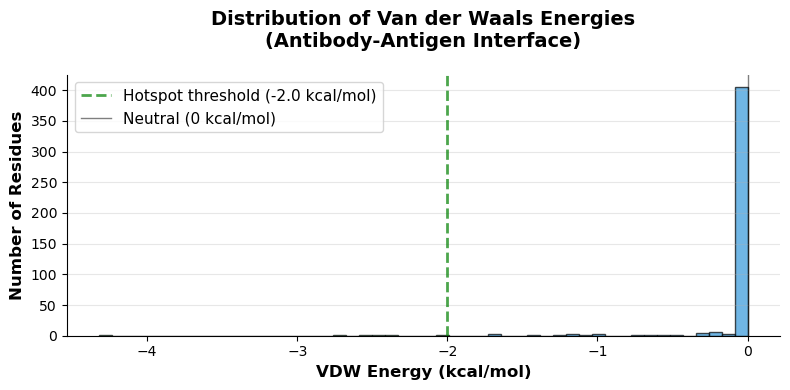


Energy Distribution:
  Strong favorable (< -2.0):     5 residues
  Favorable (-2.0 to 0):         27 residues
  Slightly unfavorable (0 to 1): 404 residues
  Unfavorable (> 1.0):           0 residues


In [12]:
# Create histogram of VDW energies
fig, ax = plt.subplots(figsize=(8, 4))

energies = list(vdw_ab_ag.values())

# Create histogram with color coding
n, bins, patches = ax.hist(energies, bins=50, edgecolor='black', alpha=0.7)

# Color code by energy
for i, patch in enumerate(patches):
    bin_center = (bins[i] + bins[i+1]) / 2
    if bin_center < -2.0:
        patch.set_facecolor('#27ae60')  # Green: strong favorable
    elif bin_center < 0:
        patch.set_facecolor('#3498db')  # Blue: favorable
    elif bin_center < 1.0:
        patch.set_facecolor('#f39c12')  # Orange: slightly unfavorable
    else:
        patch.set_facecolor('#e74c3c')  # Red: unfavorable/clash

# Add threshold line for hotspots
ax.axvline(-2.0, color='green', linestyle='--', linewidth=2, 
           label='Hotspot threshold (-2.0 kcal/mol)', alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=1, 
           label='Neutral (0 kcal/mol)', alpha=0.5)

ax.set_xlabel('VDW Energy (kcal/mol)', fontweight='bold', fontsize=12)
ax.set_ylabel('Number of Residues', fontweight='bold', fontsize=12)
ax.set_title('Distribution of Van der Waals Energies\n(Antibody-Antigen Interface)', 
             fontweight='bold', fontsize=14, pad=20)
ax.legend(fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print distribution statistics
print(f"\nEnergy Distribution:")
print(f"  Strong favorable (< -2.0):     {sum(1 for e in energies if e < -2.0)} residues")
print(f"  Favorable (-2.0 to 0):         {sum(1 for e in energies if -2.0 <= e < 0)} residues")
print(f"  Slightly unfavorable (0 to 1): {sum(1 for e in energies if 0 <= e < 1)} residues")
print(f"  Unfavorable (> 1.0):           {sum(1 for e in energies if e >= 1)} residues")

### Top Hotspots Bar Chart

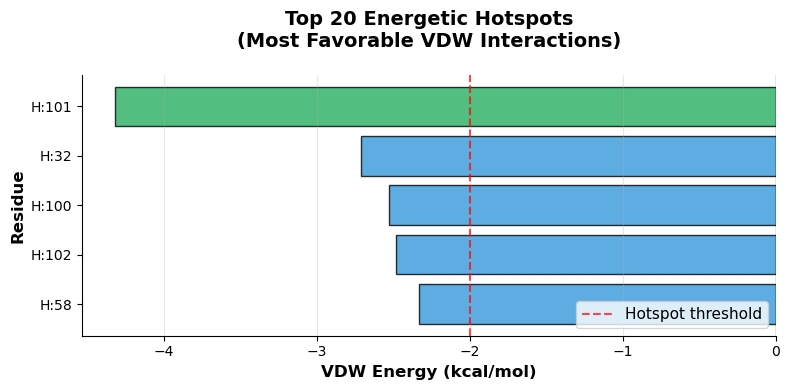

Note: More negative (left) = stronger favorable interaction.
      Green bars indicate very strong hotspots (< -3.0 kcal/mol).


In [13]:
# Plot top 20 hotspots
top_20_hotspots = hotspots[:20]

residue_labels = [res_id.split()[-1] for res_id, _ in top_20_hotspots]
energy_values = [energy for _, energy in top_20_hotspots]

fig, ax = plt.subplots(figsize=(8, 4))

colors = ['#27ae60' if e < -3.0 else '#3498db' for e in energy_values]

ax.barh(range(len(residue_labels)), energy_values, color=colors, 
        alpha=0.8, edgecolor='black')
ax.set_yticks(range(len(residue_labels)))
ax.set_yticklabels(residue_labels, fontsize=10)
ax.invert_yaxis()

ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.axvline(-2.0, color='red', linestyle='--', linewidth=1.5, 
           label='Hotspot threshold', alpha=0.7)

ax.set_xlabel('VDW Energy (kcal/mol)', fontweight='bold', fontsize=12)
ax.set_ylabel('Residue', fontweight='bold', fontsize=12)
ax.set_title('Top 20 Energetic Hotspots\n(Most Favorable VDW Interactions)', 
             fontweight='bold', fontsize=14, pad=20)
ax.legend(loc='lower right', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Note: More negative (left) = stronger favorable interaction.")
print("      Green bars indicate very strong hotspots (< -3.0 kcal/mol).")

### Chain Comparison

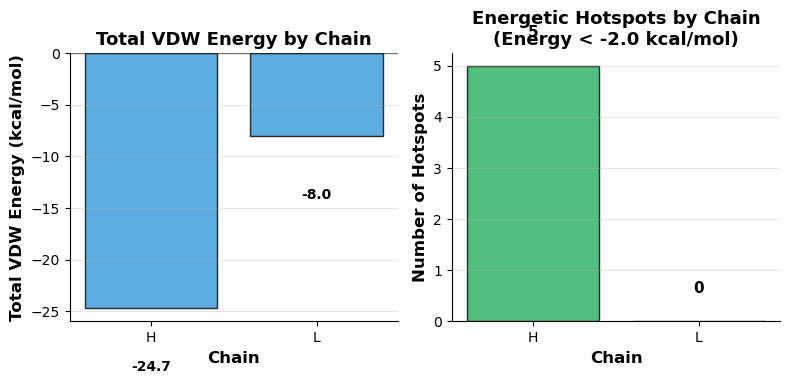


Chain with most energetic hotspots: H (5 hotspots)


In [14]:
# Compare energetic contributions by chain
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

chains = sorted(chain_summary.keys())
total_energies = [chain_summary[c]['total_energy'] for c in chains]
favorable_energies = [chain_summary[c]['favorable_energy'] for c in chains]
num_hotspots = [chain_summary[c]['num_hotspots'] for c in chains]

# Plot 1: Total energy by chain
ax1.bar(chains, total_energies, color='#3498db', alpha=0.8, edgecolor='black')
ax1.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax1.set_xlabel('Chain', fontweight='bold', fontsize=12)
ax1.set_ylabel('Total VDW Energy (kcal/mol)', fontweight='bold', fontsize=12)
ax1.set_title('Total VDW Energy by Chain', fontweight='bold', fontsize=13)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (chain, energy) in enumerate(zip(chains, total_energies)):
    ax1.text(i, energy - 5, f'{energy:.1f}', 
             ha='center', va='top', fontweight='bold', fontsize=10)

# Plot 2: Number of hotspots by chain
ax2.bar(chains, num_hotspots, color='#27ae60', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Chain', fontweight='bold', fontsize=12)
ax2.set_ylabel('Number of Hotspots', fontweight='bold', fontsize=12)
ax2.set_title('Energetic Hotspots by Chain\n(Energy < -2.0 kcal/mol)', 
              fontweight='bold', fontsize=13)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (chain, count) in enumerate(zip(chains, num_hotspots)):
    ax2.text(i, count + 0.5, f'{int(count)}', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Identify chain with most hotspots
max_hotspot_chain = chains[num_hotspots.index(max(num_hotspots))]
print(f"\nChain with most energetic hotspots: {max_hotspot_chain} ({int(max(num_hotspots))} hotspots)")

### Energy vs Residue Position

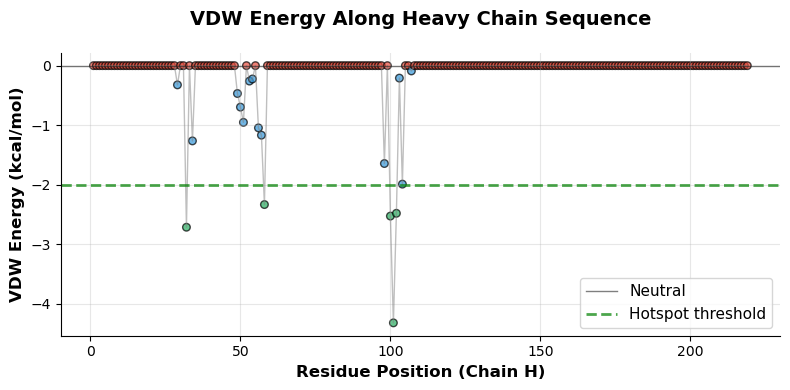

Note: Green points are energetic hotspots (< -2.0 kcal/mol).
      Blue points are favorable, red points are unfavorable.


In [16]:
# Plot energy along sequence for heavy chain
chain_h_data = {res_id: energy for res_id, energy in vdw_ab_ag.items() 
                if 'H:' in res_id or ' H_' in res_id or res_id.split()[1][0] == 'H'}

if chain_h_data:
    # Extract residue numbers
    res_data = []
    for res_id, energy in chain_h_data.items():
        if ':' in res_id:
            resnum = int(''.join(filter(str.isdigit, res_id.split(':')[1])))
        else:
            parts = res_id.split('_')
            resnum = int(''.join(filter(str.isdigit, parts[-1]))) if parts else 0
        res_data.append((resnum, energy))
    
    res_data.sort(key=lambda x: x[0])
    resnums = [r[0] for r in res_data]
    energies_seq = [r[1] for r in res_data]
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Color code points
    colors = ['#27ae60' if e < -2.0 else '#3498db' if e < 0 else '#e74c3c' 
              for e in energies_seq]
    
    ax.scatter(resnums, energies_seq, c=colors, s=30, alpha=0.7, edgecolors='black')
    ax.plot(resnums, energies_seq, color='gray', linewidth=1, alpha=0.5)
    
    ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5, label='Neutral')
    ax.axhline(-2.0, color='green', linestyle='--', linewidth=2, 
               label='Hotspot threshold', alpha=0.7)
    
    ax.set_xlabel('Residue Position (Chain H)', fontweight='bold', fontsize=12)
    ax.set_ylabel('VDW Energy (kcal/mol)', fontweight='bold', fontsize=12)
    ax.set_title('VDW Energy Along Heavy Chain Sequence', 
                 fontweight='bold', fontsize=14, pad=20)
    ax.legend(loc='lower right', fontsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Note: Green points are energetic hotspots (< -2.0 kcal/mol).")
    print("      Blue points are favorable, red points are unfavorable.")
else:
    print("No heavy chain data available for plotting.")

## 8. Export to DataFrame

Convert VDW energy results to pandas DataFrame for analysis.

In [17]:
# Create DataFrame
df_data = []

for res_id, energy in vdw_ab_ag.items():
    # Parse residue ID
    parts = res_id.split()
    resname = parts[0] if parts else "UNK"
    
    if ':' in res_id:
        chain_pos = res_id.split(':')[0].split()[-1]
        resnum = res_id.split(':')[1]
    else:
        chain_pos = parts[1][0] if len(parts) > 1 else "?"
        resnum = parts[1][1:] if len(parts) > 1 else "?"
    
    df_data.append({
        'residue_id': res_id,
        'resname': resname,
        'chain': chain_pos,
        'resnum': resnum,
        'vdw_energy': energy,
        'is_hotspot': energy <= -2.0,
        'is_favorable': energy < 0,
        'is_unfavorable': energy >= 0
    })

df_vdw = pd.DataFrame(df_data)

print("DataFrame created successfully!")
print(f"\nVDW DataFrame: {df_vdw.shape[0]} rows × {df_vdw.shape[1]} columns")
print(f"Columns: {list(df_vdw.columns)}")

print(f"\nFirst 10 rows (sorted by energy):")
df_vdw.sort_values('vdw_energy').head(10)

DataFrame created successfully!

VDW DataFrame: 436 rows × 8 columns
Columns: ['residue_id', 'resname', 'chain', 'resnum', 'vdw_energy', 'is_hotspot', 'is_favorable', 'is_unfavorable']

First 10 rows (sorted by energy):


,residue_id,resname,chain,resnum,vdw_energy,is_hotspot,is_favorable,is_unfavorable
100,ARG H:101,ARG,H,101,-4.318713,True,True,False
31,TYR H:32,TYR,H,32,-2.713247,True,True,False
99,TYR H:100,TYR,H,100,-2.525797,True,True,False
101,PHE H:102,PHE,H,102,-2.479454,True,True,False
57,ASN H:58,ASN,H,58,-2.332421,True,True,False
103,MET H:104,MET,H,104,-1.989616,False,True,False
275,TYR L:57,TYR,L,57,-1.673346,False,True,False
97,ARG H:98,ARG,H,98,-1.643532,False,True,False
314,ARG L:96,ARG,L,96,-1.437292,False,True,False
33,TYR H:34,TYR,H,34,-1.263589,False,True,False


## 9. Formatted Report

Use the built-in reporting function for a comprehensive summary.

In [19]:
# Generate formatted report
print_vdw_report(
    vdw_ab_ag,
    top_n=20,                # Show top 20 hotspots
    energy_threshold=-2.0    # Hotspot threshold
)

VDW ENERGY ANALYSIS REPORT

--- OVERALL SUMMARY ---
Total residues:        436
Total VDW energy:          -32.73 kcal/mol
Favorable energy:          -32.73 kcal/mol
Unfavorable energy:          0.00 kcal/mol
Average per residue:        -0.08 kcal/mol

--- CHAIN SUMMARY ---
Chain    #Res     Total           Favorable       Hotspots    
--------------------------------------------------------------------------------
L        217             -8.03        -8.03 0           
H        219            -24.70       -24.70 5           

--- TOP 5 ENERGETIC HOTSPOTS (Energy < -2.0 kcal/mol) ---
Residue      Energy (kcal/mol)   
----------------------------------------
ARG H:101              -4.31871
TYR H:32               -2.71325
TYR H:100              -2.52580
PHE H:102              -2.47945
ASN H:58               -2.33242

Total hotspots: 5


## 10. Calculate Antigen → Antibody Energies

Reverse the calculation to see antigen residues interacting with antibody.

In [20]:
# Calculate reverse: Antigen residues → Antibody
vdw_ag_ab = per_residue_LJ_decomposition(
    cx,
    left_exprs="A",          # Antigen (decompose these)
    right_exprs=["H", "L"],  # Antibody (interaction partners)
    ignore_h=True,
    cutoff=5.0
)

print("=" * 80)
print("VDW ENERGY CALCULATION: ANTIGEN → ANTIBODY".center(80))
print("=" * 80)
print(f"Antigen residues analyzed: {len(vdw_ag_ab)}")

# Identify top antigen hotspots
ag_hotspots = identify_energetic_hotspots(vdw_ag_ab, energy_threshold=-2.0)

print(f"\nAntigen energetic hotspots: {len(ag_hotspots)}")
print(f"\nTop 10 antigen hotspots:")
print(f"{'Rank':<6}{'Residue':<20}{'Energy (kcal/mol)':<20}")
print("-" * 80)

for i, (res_id, energy) in enumerate(ag_hotspots[:10], 1):
    print(f"{i:<6}{res_id:<20}{energy:>18.5f}")

print("=" * 80)

                   VDW ENERGY CALCULATION: ANTIGEN → ANTIBODY                   
Antigen residues analyzed: 113

Antigen energetic hotspots: 6

Top 10 antigen hotspots:
Rank  Residue             Energy (kcal/mol)   
--------------------------------------------------------------------------------
1     PRO A:59                      -5.91834
2     LYS A:101                     -4.36264
3     LYS A:48                      -2.38682
4     PRO A:53                      -2.27438
5     ARG A:56                      -2.20229
6     SER A:57                      -2.16256


## 11. Key Findings Summary

In [21]:
print("=" * 80)
print("KEY FINDINGS: VDW ENERGY ANALYSIS SUMMARY".center(80))
print("=" * 80)

print("\n⚡ Overall Energetics (Antibody → Antigen):")
print(f"   • Total residues analyzed: {len(vdw_ab_ag)}")
print(f"   • Total VDW energy: {total_energy:.2f} kcal/mol")
print(f"   • Favorable energy: {favorable:.2f} kcal/mol ({favorable/total_energy*100:.1f}%)")
print(f"   • Unfavorable energy: {unfavorable:.2f} kcal/mol")
print(f"   • Energetic hotspots (< -2.0): {len(hotspots)}")

print("\n⛓️ Chain-Level Contributions:")
for chain_id, stats in sorted(chain_summary.items()):
    print(f"   • Chain {chain_id}:")
    print(f"     - Total energy: {stats['total_energy']:.2f} kcal/mol")
    print(f"     - Hotspots: {int(stats['num_hotspots'])}")
    print(f"     - Avg per residue: {stats['avg_energy']:.2f} kcal/mol")

print("\n🔥 Top Energetic Hotspot:")
top_hotspot_id, top_hotspot_energy = hotspots[0]
print(f"   • {top_hotspot_id}")
print(f"   • Energy: {top_hotspot_energy:.5f} kcal/mol")
print(f"   • This residue has the strongest VDW interaction with the partner")

print("\n🎯 Energetic Distribution:")
print(f"   • Strong hotspots (< -2.0): {sum(1 for e in all_energies if e < -2.0)}")
print(f"   • Favorable (-2.0 to 0): {sum(1 for e in all_energies if -2.0 <= e < 0)}")
print(f"   • Unfavorable (> 0): {sum(1 for e in all_energies if e >= 0)}")

print("\n🔄 Reciprocal Analysis (Antigen → Antibody):")
print(f"   • Antigen residues analyzed: {len(vdw_ag_ab)}")
print(f"   • Antigen hotspots: {len(ag_hotspots)}")
print(f"   • Total antigen VDW energy: {sum(vdw_ag_ab.values()):.2f} kcal/mol")

print("\n" + "=" * 80)

                   KEY FINDINGS: VDW ENERGY ANALYSIS SUMMARY                    

⚡ Overall Energetics (Antibody → Antigen):
   • Total residues analyzed: 436
   • Total VDW energy: -14.37 kcal/mol
   • Favorable energy: -32.73 kcal/mol (227.8%)
   • Unfavorable energy: 0.00 kcal/mol
   • Energetic hotspots (< -2.0): 5

⛓️ Chain-Level Contributions:
   • Chain H:
     - Total energy: -24.70 kcal/mol
     - Hotspots: 5
     - Avg per residue: -0.11 kcal/mol
   • Chain L:
     - Total energy: -8.03 kcal/mol
     - Hotspots: 0
     - Avg per residue: -0.04 kcal/mol

🔥 Top Energetic Hotspot:
   • ARG H:101
   • Energy: -4.31871 kcal/mol
   • This residue has the strongest VDW interaction with the partner

🎯 Energetic Distribution:
   • Strong hotspots (< -2.0): 5
   • Favorable (-2.0 to 0): 27
   • Unfavorable (> 0): 404

🔄 Reciprocal Analysis (Antigen → Antibody):
   • Antigen residues analyzed: 113
   • Antigen hotspots: 6
   • Total antigen VDW energy: -32.73 kcal/mol



## END 